In [291]:
import numpy as np
import scipy.ndimage
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from skimage import data, img_as_float
from skimage.util import random_noise
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [292]:
def is_valid_image(img):
    min_pixel = np.min(img)
    max_pixel = np.max(img)
    min_pixel = round(min_pixel * 255)
    max_pixel = round(max_pixel * 255)
    # print(f"Min pixel value: {min_pixel}")
    # print(f"Max pixel value: {max_pixel}")
    return min_pixel >= 0 and max_pixel <= 255

In [293]:
def assert_valid_image(img):
    min_pixel = np.min(img)
    max_pixel = np.max(img)
    min_pixel = round(min_pixel * 255)
    max_pixel = round(max_pixel * 255)
    # print(f"Min pixel value: {min_pixel}")
    # print(f"Max pixel value: {max_pixel}")
    assert min_pixel >= 0 and max_pixel <= 255, f"Expected pixel values to be in range [0, 1], got min: {min_pixel}, max: {max_pixel}"

In [294]:
def gradient(x):
    grad_x = np.roll(x, -1, axis=1) - x
    grad_y = np.roll(x, -1, axis=0) - x
    return grad_x, grad_y

def div(px, py):
    div_x = px - np.roll(px, 1, axis=1)
    div_y = py - np.roll(py, 1, axis=0)
    return div_x + div_y

In [295]:
def tgv_denoising(image, alpha0, alpha1, max_iter=100, tol=1e-4):
    u = image.copy()
    p = np.zeros((2, *image.shape))  # dual variable for u
    q = np.zeros((2, *image.shape))  # dual variable for v

    tau = 1.0 / (4.0 * alpha1)
    sigma = 1.0 / tau

    for _ in tqdm(range(max_iter)):
        # assert_valid_image(u)
        u_old = u.copy()

        # Compute gradients
        grad_u = np.stack(gradient(u), axis=0)
        v = u - alpha0 * div(p[0], p[1])

        # Dual update
        p += sigma * alpha0 * grad_u
        norm_p = np.maximum(1.0, np.sqrt(p[0]**2 + p[1]**2))
        p[0] /= norm_p
        p[1] /= norm_p

        grad_v = np.stack(gradient(v), axis=0)
        q += sigma * alpha1 * grad_v
        norm_q = np.maximum(1.0, np.sqrt(q[0]**2 + q[1]**2))
        q[0] /= norm_q
        q[1] /= norm_q

        # Primal update
        u += tau * div(p[0], p[1])
        u = (u + tau * image) / (1.0 + tau)

        # Check convergence
        if np.linalg.norm(u - u_old) < tol:
            break

    # assert_valid_image(u)
    return u

In [296]:
def plot_results(img_np, noisy_img_np, denoised_img_np):
    img_PIL = Image.fromarray((img_np * 255).astype(np.uint8))
    noisy_img_PIL = Image.fromarray((noisy_img_np * 255).astype(np.uint8))
    denoised_img_PIL = Image.fromarray((denoised_img_np * 255).astype(np.uint8))
    # Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_PIL, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(noisy_img_PIL, cmap='gray')
    ax[1].set_title('Noisy Image')
    ax[1].axis('off')
    ax[2].imshow(denoised_img_PIL, cmap='gray')
    ax[2].set_title('Denoised Image')
    ax[2].axis('off')
    plt.show()

In [297]:
# Load sample image
img_np = img_as_float(data.camera())
# noisy_img_np = random_noise(img_np, mode='s&p', amount=0.1)
noisy_img_np = random_noise(img_np, mode='gaussian', var=0.01)

  0%|          | 0/256 [00:00<?, ?it/s]

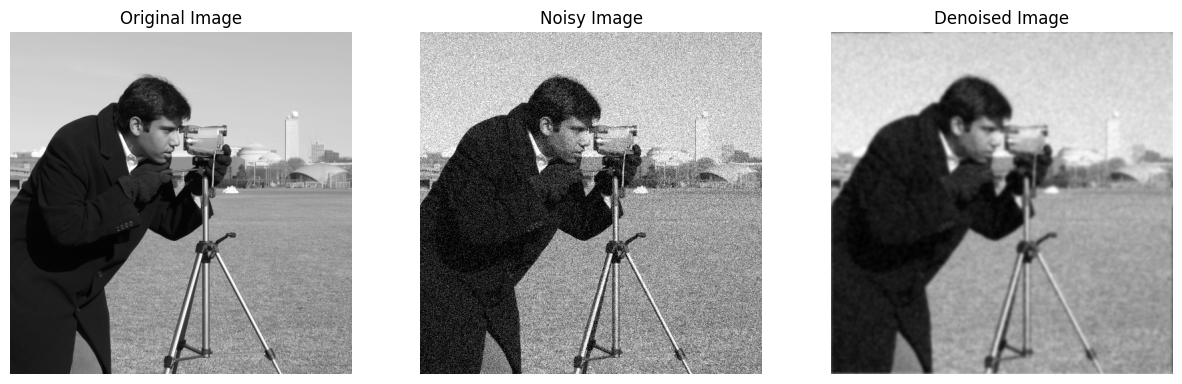

In [298]:
alpha0 = 0.01
alpha1 = 0.2

denoised_img_np = tgv_denoising(noisy_img_np, alpha0, alpha1, max_iter=256, tol=1e-9)
plot_results(img_np, noisy_img_np, denoised_img_np)

In [299]:
def ternary_search_2d(min_x, max_x, min_y, max_y, compute, is_best, num_iters):
    assert min_x < max_x, f"min_x: {min_x}, max_x: {max_x}"
    assert min_y < max_y, f"min_y: {min_y}, max_y: {max_y}"
    for _ in tqdm(range(num_iters)):
        mid_x_1 = min_x + (max_x - min_x) / 3
        mid_x_2 = min_x + 2 * (max_x - min_x) / 3
        mid_y_1 = min_y + (max_y - min_y) / 3
        mid_y_2 = min_y + 2 * (max_y - min_y) / 3
        res_x1_y1 = compute(mid_x_1, mid_y_1)
        res_x1_y2 = compute(mid_x_1, mid_y_2)
        res_x2_y1 = compute(mid_x_2, mid_y_1)
        res_x2_y2 = compute(mid_x_2, mid_y_2)
        print(f"{res_x1_y1} {res_x1_y2} {res_x2_y1} {res_x2_y2}")
        max_res = is_best(res_x1_y1, res_x1_y2, res_x2_y1, res_x2_y2)
        if max_res == res_x1_y1:
            max_x = mid_x_2
            max_y = mid_y_2
            print(f"1: {max_res}")
        if max_res == res_x1_y2:
            max_x = mid_x_2
            min_y = mid_y_1
            print(f"2: {max_res}")
        if max_res == res_x2_y1:
            min_x = mid_x_1
            max_y = mid_y_2
            print(f"3: {max_res}")
        if max_res == res_x2_y2:
            min_x = mid_x_1
            min_y = mid_y_1
            print(f"4: {max_res}")
        print(f"min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}")
    return (min_x + max_x) / 2, (min_y + max_y) / 2

In [300]:
def get_psnr(alpha0, alpha1):
    denoised_img_np = tgv_denoising(
        image=noisy_img_np, 
        alpha0=alpha0, 
        alpha1=alpha1, 
        max_iter=256, tol=1e-9)
    
    # min_pixel = np.min(denoised_img_np)
    # max_pixel = np.max(denoised_img_np)
    # print(f"alpha0: {alpha0}, alpha1: {alpha1}")
    # print(f"Min pixel value: {min_pixel}, Max pixel value: {max_pixel}")
    
    # assert_valid_image(denoised_img_np)
    if is_valid_image(denoised_img_np):
        psnr = peak_signal_noise_ratio(img_np, denoised_img_np)
    else:
        psnr = 0
    # print(f"PSNR: {psnr}")
    
    # denoised_img_PIL = Image.fromarray((denoised_img_np * 255).astype(np.uint8))
    # plt.imshow(denoised_img_PIL, cmap='gray')
    # plt.axis('off')
    # plt.show()
    
    return psnr

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

21.944725012057702 22.032133937101854 22.03319813689407 0
3: 22.03319813689407
min_x: 0.334, max_x: 1, min_y: 0.001, max_y: 0.667


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

21.95997674505469 22.042529862134387 22.006082851951238 0
2: 22.042529862134387
min_x: 0.334, max_x: 0.778, min_y: 0.223, max_y: 0.667


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

22.009338459816952 22.043256666991233 22.037637207734964 0
2: 22.043256666991233
min_x: 0.334, max_x: 0.63, min_y: 0.371, max_y: 0.667


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

22.023514757315855 22.04162264124423 22.043193998242923 22.058118408839178
4: 22.058118408839178
min_x: 0.4326666666666667, max_x: 0.63, min_y: 0.4696666666666667, max_y: 0.667


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

22.048737508458068 22.05749614443829 22.058232943176492 22.06568089777229
4: 22.06568089777229
min_x: 0.49844444444444447, max_x: 0.63, min_y: 0.5354444444444445, max_y: 0.667


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

22.06085405899229 22.065403527512704 22.065792351414125 22.069840659201162
4: 22.069840659201162
min_x: 0.5422962962962963, max_x: 0.63, min_y: 0.5792962962962963, max_y: 0.667


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

22.067104892438504 22.069679394463463 22.069949354020654 0
3: 22.069949354020654
min_x: 0.5715308641975309, max_x: 0.63, min_y: 0.5792962962962963, max_y: 0.6377654320987655


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

22.06812977606047 22.06988693986251 0 0
2: 22.06988693986251
min_x: 0.5715308641975309, max_x: 0.6105102880658436, min_y: 0.5987860082304527, max_y: 0.6377654320987655


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

22.068669803984577 22.069825275660982 22.069935641755688 22.071074558954038
4: 22.071074558954038
min_x: 0.5845240054869685, max_x: 0.6105102880658436, min_y: 0.6117791495198903, max_y: 0.6377654320987655


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

22.070296778166387 22.071042334028334 0 0
2: 22.071042334028334
min_x: 0.5845240054869685, max_x: 0.6018481938728852, min_y: 0.6204412437128487, max_y: 0.6377654320987655


  0%|          | 0/256 [00:00<?, ?it/s]

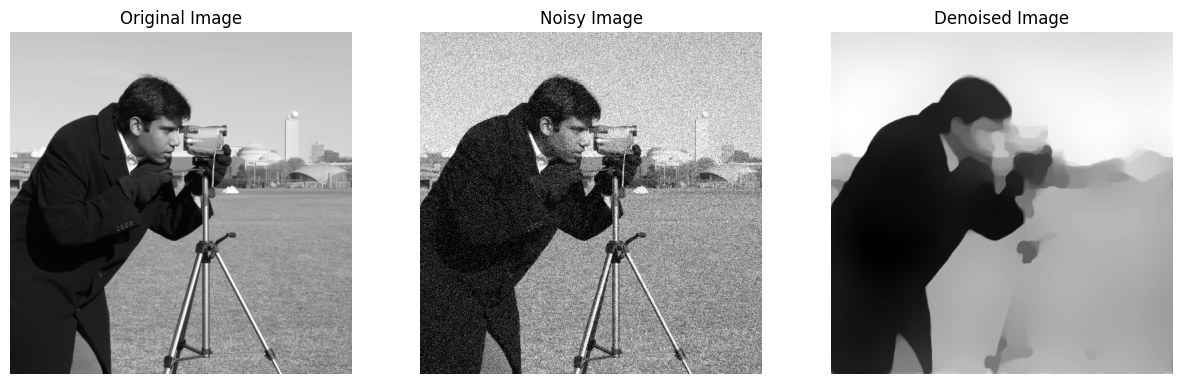

In [301]:
best_alpha0, best_alpha1 = ternary_search_2d(
    1e-3, 1, 1e-3, 1, 
    get_psnr, max, 10)

best_denoised_img_np = tgv_denoising(
    image=noisy_img_np, 
    alpha0=best_alpha0, 
    alpha1=best_alpha1, 
    max_iter=256, tol=1e-9)

plot_results(img_np, noisy_img_np, best_denoised_img_np)

In [302]:
print(f"best_alpha0: {best_alpha0}")
print(f"best_alpha1: {best_alpha1}")

best_alpha0: 0.5931860996799269
best_alpha1: 0.6291033379058071


In [303]:
# def round_to_nearest_1e_9(value):
#     return round(value, 9)

# # Example usage:
# number = 3.141592653589793
# rounded_number = round_to_nearest_1e_9(number)
# print(f"Original number: {number}")
# print(f"Rounded to nearest 1e-9: {rounded_number}")